In [1]:
# importer les différents dictionnaires python

import os
import pandas as pd
import numpy as np
import tensorflow as tf
import joblib
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, Activation, Dropout
from tensorflow.keras import callbacks

In [2]:
os.chdir("C:/Users/antho/Projet_NBA")
df = pd.read_pickle('Nettoyage_données_NBA.pkl')

In [3]:
df.drop('zone_pct', axis = 1, inplace = True)

In [4]:
df = pd.get_dummies(data = df)

In [5]:
# séparation des données en features et target

pd.set_option('display.max_columns', None)
target = df['shot_made_flag']
features = df.drop('shot_made_flag', axis = 1)

In [6]:
# séparation en un ensemble d'entraînement et un ensemble de test

x_train,x_test,y_train,y_test = train_test_split(features,target, test_size = 0.2, random_state = np.random)

In [7]:
# standardisation des données (x_train et x_test)

scaler = preprocessing.StandardScaler().fit(x_train)

x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [8]:
y_train = to_categorical(y_train, dtype = 'int')
y_test = to_categorical(y_test, dtype = 'int')

In [14]:
# 1er modèle

In [14]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 82)]              0         
                                                                 
 dense (Dense)               (None, 320)               26560     
                                                                 
 dropout (Dropout)           (None, 320)               0         
                                                                 
 dense_1 (Dense)             (None, 160)               51360     
                                                                 
 dense_2 (Dense)             (None, 2)                 322       
                                                                 
Total params: 78,242
Trainable params: 78,242
Non-trainable params: 0
_________________________________________________________________


In [9]:
#architecture du modèle
import matplotlib.pyplot as plt

input_model = Input(shape = x_train_scaled.shape[1])
first_layer = Dense(units = 320, activation = 'relu')
second_layer= Dropout(rate = 0.2)
third_layer = Dense(units = 160, activation = 'relu')
fourth_layer= Dropout(rate = 0.2)
fifth_layer = Dense(units = 2, activation = 'softmax')

x = first_layer(input_model)
x = second_layer(x)
x = third_layer(x)
x = fourth_layer(x)
output_model = fifth_layer(x)
model = Model(inputs = input_model, outputs = output_model)

# callbacks
early_stopping = callbacks.EarlyStopping(monitor = 'val_loss', verbose = 1, patience = 5,
                                             mode = 'min', restore_best_weights = True)
lr_plateau = callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 3, mode = 'min', verbose = 2)

#compilation du modèle
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

#entraînement du modèle
history = model.fit(x_train_scaled, y_train, batch_size = 300, epochs = 20, validation_split = 0.2,
                        validation_data = (x_test_scaled, y_test), callbacks = [early_stopping,lr_plateau])
joblib.dump(model, 'my_model_Deep_Learning_RNN.pkl')

Epoch 1/20
664/664 [==============================] - 12s 14ms/step - loss: 0.6305 - accuracy: 0.6444 - val_loss: 0.6225 - val_accuracy: 0.6493 - lr: 0.0010
Epoch 2/20
664/664 [==============================] - 9s 13ms/step - loss: 0.6222 - accuracy: 0.6508 - val_loss: 0.6200 - val_accuracy: 0.6526 - lr: 0.0010
Epoch 3/20
664/664 [==============================] - 9s 13ms/step - loss: 0.6198 - accuracy: 0.6538 - val_loss: 0.6188 - val_accuracy: 0.6526 - lr: 0.0010
Epoch 4/20
664/664 [==============================] - 8s 13ms/step - loss: 0.6182 - accuracy: 0.6546 - val_loss: 0.6177 - val_accuracy: 0.6540 - lr: 0.0010
Epoch 5/20
664/664 [==============================] - 8s 13ms/step - loss: 0.6171 - accuracy: 0.6555 - val_loss: 0.6166 - val_accuracy: 0.6538 - lr: 0.0010
Epoch 6/20
664/664 [==============================] - 8s 13ms/step - loss: 0.6159 - accuracy: 0.6566 - val_loss: 0.6168 - val_accuracy: 0.6531 - lr: 0.0010
Epoch 7/20
664/664 [==============================] - 8s 13ms/s

['my_model_Deep_Learning_RNN.pkl']

In [10]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

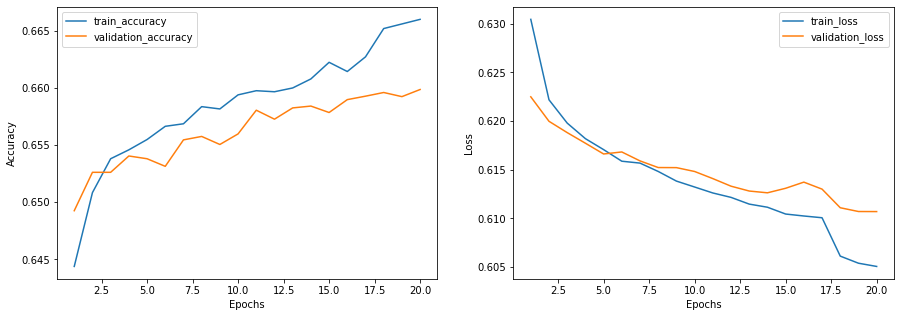

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(np.arange(1,21),train_acc, label = 'train_accuracy')
plt.plot(np.arange(1,21),val_acc, label = 'validation_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend();

plt.subplot(122)
plt.plot(np.arange(1,21),train_loss, label = 'train_loss')
plt.plot(np.arange(1,21),val_loss, label = 'validation_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend();

In [12]:
y_prob = model.predict(x_test_scaled)
y_pred_class = tf.argmax(y_prob, axis = 1).numpy()
y_test_class = y_test.argmax(axis = 1)

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

score_rnn = accuracy_score(y_test_class,y_pred_class)
np.save('score_Deep_Learning_RNN',score_rnn)
print(confusion_matrix(y_test_class,y_pred_class))

1555/1555 [==============================] - 6s 4ms/step
[[20213  5957]
 [10966 12616]]


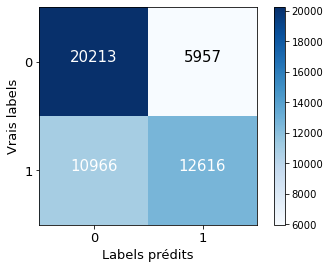

In [14]:
#matrice de confusion colorée
from sklearn.metrics import confusion_matrix
import itertools
cnf_matrix = confusion_matrix(y_test_class,y_pred_class)

classes = range(0,2)

plt.figure()

plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, size = 13)
plt.yticks(tick_marks, classes, size = 13)

for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, cnf_matrix[i, j],
             horizontalalignment = "center",
             fontdict = {'fontsize' : 15},
             color = "white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

plt.ylabel('Vrais labels', size = 13)
plt.xlabel('Labels prédits', size = 13)
plt.show()

In [23]:
import keras_tuner as kt

def model_builder(hp):
    input_model = Input(shape = x_train_scaled.shape[1])
    
    # les variables à faire varier
    hp.units_1 = hp.Int('units',min_value = 64, max_value = 512, step = 64)
    hp.units_2 = hp.Int('units',min_value = 64, max_value = 512, step = 64)
    hp_dropout = hp.Float('taux',min_value = 0.2, max_value = 0.6, step =0.2)
    hp_activation_dense = hp.Choice( "dense_activation", values=["relu", "tanh"])
    
    # les différentes couches
    first_layer = Dense(units = hp.units_1, activation = hp_activation_dense)
    second_layer= Dropout(rate = hp_dropout)
    third_layer = Dense(units = hp.units_2, activation = hp_activation_dense)
    fourth_layer= Dropout(rate = hp_dropout)
    fifth_layer = Dense(units = 2, activation = 'sotfmax')
    
    x = first_layer(input_model)
    x = second_layer(x)
    x = third_layer(x)
    x = fourth_layer(x)
    output_model = fifth_layer(x)
        
    model = Model(inputs = input_model, outputs = output_model)

    #callbacks
    early_stopping = callbacks.EarlyStopping(monitor = 'val_loss', verbose = 1, patience = 5,
                                         mode = 'min', restore_best_weights = True)
    lr_plateau = callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 2, mode = 'min', verbose = 2)

    #compilation du modèle
    hp.lr = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4])
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = hp.lr),
                  loss = 'categorical_crossentropy', metrics = ['accuracy'])

    #entraînement du modèle
    history = model.fit(x_train_scaled, y_train, batch_size = 200, epochs = 20, validation_split = 0.1,
                    validation_data = (x_test_scaled, y_test), callbacks = [early_stopping,lr_plateau]) 
    
    return model

In [24]:
tuner = kt.Hyperband(model_builder,
                     objective = 'val_accuracy', 
                     max_epochs = 20,
                     factor = 4,
                     directory = 'my_dir',
                     project_name = 'hyper_tuning_DL_MSPy') 

Epoch 1/20
996/996 [==============================] - 5s 4ms/step - loss: 0.6403 - accuracy: 0.6260 - val_loss: 0.6369 - val_accuracy: 0.6304 - lr: 0.0010
Epoch 2/20
996/996 [==============================] - 4s 4ms/step - loss: 0.6367 - accuracy: 0.6294 - val_loss: 0.6362 - val_accuracy: 0.6316 - lr: 0.0010
Epoch 3/20
996/996 [==============================] - 4s 4ms/step - loss: 0.6355 - accuracy: 0.6303 - val_loss: 0.6348 - val_accuracy: 0.6327 - lr: 0.0010
Epoch 4/20
996/996 [==============================] - 4s 4ms/step - loss: 0.6344 - accuracy: 0.6310 - val_loss: 0.6344 - val_accuracy: 0.6330 - lr: 0.0010
Epoch 5/20
996/996 [==============================] - 4s 4ms/step - loss: 0.6336 - accuracy: 0.6317 - val_loss: 0.6343 - val_accuracy: 0.6328 - lr: 0.0010
Epoch 6/20
996/996 [==============================] - 4s 4ms/step - loss: 0.6330 - accuracy: 0.6323 - val_loss: 0.6336 - val_accuracy: 0.6339 - lr: 0.0010
Epoch 7/20
996/996 [==============================] - 4s 4ms/step - lo

In [ ]:

tuner.search(x_train_scaled, y_train, epochs=20, steps_per_epoch=20, validation_data = (x_test_scaled,y_test),
             verbose = 1, validation_steps=3, callbacks = [early_stopping,lr_plateau])




Trial 14 Complete [00h 02m 45s]
val_accuracy: 0.6348488330841064

Best val_accuracy So Far: 0.6351704597473145
Total elapsed time: 00h 30m 49s

Search: Running Trial #15

Value             |Best Value So Far |Hyperparameter
64                |256               |units
relu              |relu              |dense_activation
7                 |3                 |tuner/epochs
3                 |0                 |tuner/initial_epoch
2                 |2                 |tuner/bracket
1                 |0                 |tuner/round
0004              |None              |tuner/trial_id

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\dense_2
......vars
.........0
.........1
...layers\input_layer
......vars
...metrics\mean
......vars
.........0
.........1
...metrics\mean_metric_wrapper
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
...

In [16]:
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
The hyperparameter search is complete.\n The optimal number of units in the first densely-connected
layer is {best_hps.get('units')}.\n The optimal learning rate for the optimizer is {best_hps.get('learning_rate')}. \n 
L'activation optimale est {best_hps.get('dense_activation')}.
""")


The hyperparameter search is complete.
 The optimal number of units in the first densely-connected
layer is 320.
 The optimal learning rate for the optimizer is 0.001. 
 
L'activation optimale est relu.

